# Here, We are going to use VGG16, MobileNet and RESNET50 to train the model. which are pretrained model 

In [3]:
# Importing the Keras libraries and packages

from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2

train_dir = "/kaggle/input/american-sign-language-recognition/training_set"
train_dir2 = "/kaggle/input/american-sign-language-09az/American"
eval_dir = "/kaggle/input/american-sign-language-recognition/test_set"

# 2. Loading the data (custom)

In [5]:
#Helper function to load images from given directories
def load_images(directory):
    images = []
    label_ = []
    for idx, label in enumerate(uniq_labels):
        for i, file in enumerate(os.listdir(directory + "/" + label)):
            if i in range(200):
               filepath = directory + "/" + label + "/" + file
               image = cv2.resize(cv2.imread(filepath), (64, 64))
               images.append(image)
               label_.append(idx)
    images = np.array(images)
    labels = np.array(label_)
    return(images, labels, label_)

In [6]:
import keras

#uniq_labels = sorted(os.listdir(train_dir))
#images, labels = load_images(directory = train_dir)

#if uniq_labels == sorted(os.listdir(eval_dir)):
#   X_eval, y_eval = load_images(directory = eval_dir)

uniq_labels = sorted(os.listdir(train_dir2))
images, labels, my_classes= load_images(directory = train_dir2)


In [5]:
print(labels.shape)

(7200,)


Labels.txt file

In [6]:
import os

# Getting the subfolder names
#class_names = sorted(os.listdir(train_dir))
class_names = sorted(os.listdir(train_dir2))

# Write the class names to a label.txt file
with open("label_new.txt", "w") as f:
  for name in class_names:
    f.write(name + "\n")


In [ ]:
##Inverting the image
#images_inv = cv2.bitwise_not(images)
#X_eval_inv = cv2.bitwise_not(X_eval)


**Note:** In the train-test split I have used the stratify argument on the labels. This argument ensures that the data is split evenly along all labels 

In [7]:
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(images_inv, labels, test_size = 0.2, stratify = labels)
X_train, X_, y_train, y_ = train_test_split(images, labels, test_size = 0.3, stratify = labels)
X_eval, X_test, y_eval, y_test = train_test_split(X_, y_, test_size = 0.5)

n = len(uniq_labels)
train_n = len(X_train)
test_n = len(X_test)

print("Total number of symbols: ", n)
print("Number of training images: " , train_n)
print("Number of testing images: ", test_n)

#eval_n = len(X_eval_inv)
eval_n = len(X_eval)
print("Number of evaluation images: ", eval_n)

Total number of symbols:  36
Number of training images:  5040
Number of testing images:  1080
Number of evaluation images:  1080


In [8]:
print(y_train.shape)

(5040,)


In [9]:
import matplotlib.pyplot as plt

# Invert the colors
#inverted_image = cv2.bitwise_not(X_train)

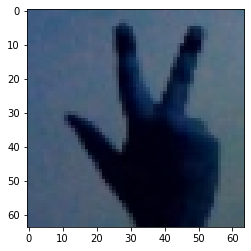

In [10]:
#inverted_image.shape
plt.imshow(X_train[0][:,])

In [11]:
#inverted_image.shape
#plt.imshow(inverted_image[0][:,])

In [12]:
uniq_labels

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

# 3. Preprocessing: One-hot enconding the data

This conversion will turn the one-dimensional array of labels into a two-dimensional array. Each row in the two-dimensional array of one-hot encoded labels corresponds to a different label.

In [13]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_eval = keras.utils.to_categorical(y_eval)

In [14]:
y_eval.shape

(1080, 36)

now just checking that is it converted or not.

In [15]:
print(y_train[0])
print(len(y_train[0]))

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
36


# 4. Preprocessing

**Normalization will help us remove distortions caused by lights and shadows in an image**

In [16]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
X_eval = X_eval.astype('float32')/255.0
#X_eval_inv = X_eval_inv.astype('float32')/255.0

# initializing all the models

# VGG16

In [17]:
#Initialising vgg16 
classifier_vgg16 = VGG16(input_shape= (64,64,3),include_top=False,weights='imagenet')

58892288/58889256 [==============================] - 0s 0us/step


# RESNET50

In [18]:
#Initialising vgg16 
classifier_resnet = ResNet50(input_shape= (64,64,3),include_top=False,weights='imagenet')

94773248/94765736 [==============================] - 1s 0us/step


# MOBILENET

In [36]:
# Neural network architecture

pretrainedModel = tf.keras.applications.MobileNet(
    input_shape=(64, 64, 3),
     include_top=False,
     weights='imagenet',
     pooling='avg'
)
pretrainedModel.trainable = False

inputs = pretrainedModel.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrainedModel.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model3 = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer_adam = tf.keras.optimizers.Adam(learning_rate = 0.005)

# Compile model
model3.compile(
    optimizer=optimizer_adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**Model for custom data**

In [20]:
#don't train existing weights for vgg16
for layer in classifier_vgg16.layers:
    layer.trainable = False

#don't train existing weights for resnet50
#for layer in classifier_resnet.layers:
    #layer.trainable = False

In [21]:
classifier1 = classifier_vgg16.output#head mode
classifier1 = Flatten()(classifier1)#adding layer of flatten
classifier1 = Dense(units=256, activation='relu')(classifier1)
classifier1 = Dropout(0.6)(classifier1)
classifier1 = Dense(units=36, activation='softmax')(classifier1)

model = Model(inputs = classifier_vgg16.input , outputs = classifier1)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
classifier2 = classifier_resnet.output#head mode
classifier2 = Flatten()(classifier2)#adding layer of flatten
classifier2 = Dropout(0.6)(classifier2)
classifier2 = Dense(units=36, activation='softmax')(classifier2)

model2 = Model(inputs = classifier_resnet.input , outputs = classifier2)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

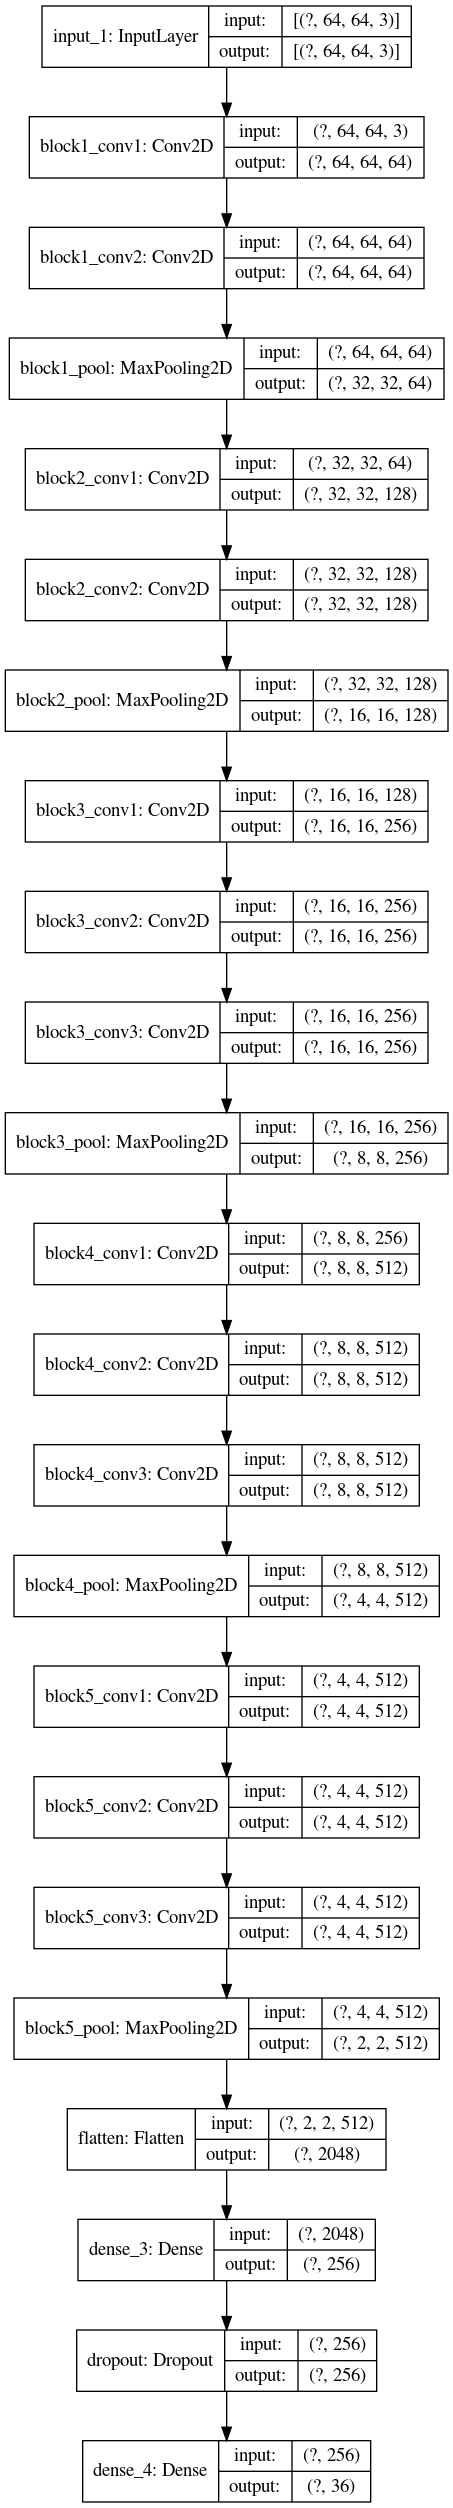

In [52]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='VGG_model_plot.png', show_shapes=True, show_layer_names=True)

In [61]:
pip install visualkeras

     |████████████████████████████████| 989 kB 4.3 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


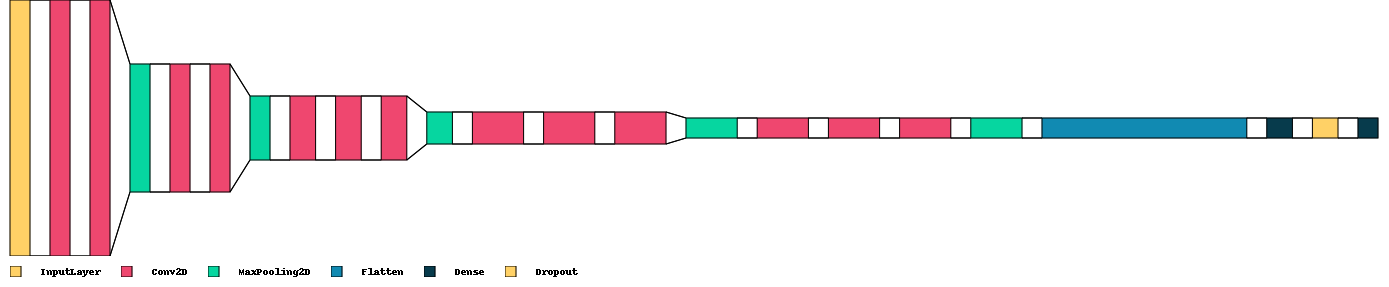

In [68]:
import visualkeras
visualkeras.layered_view(model, legend=True, draw_volume=False,spacing=20, to_file="VGGmodel_vis.png")

In [24]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

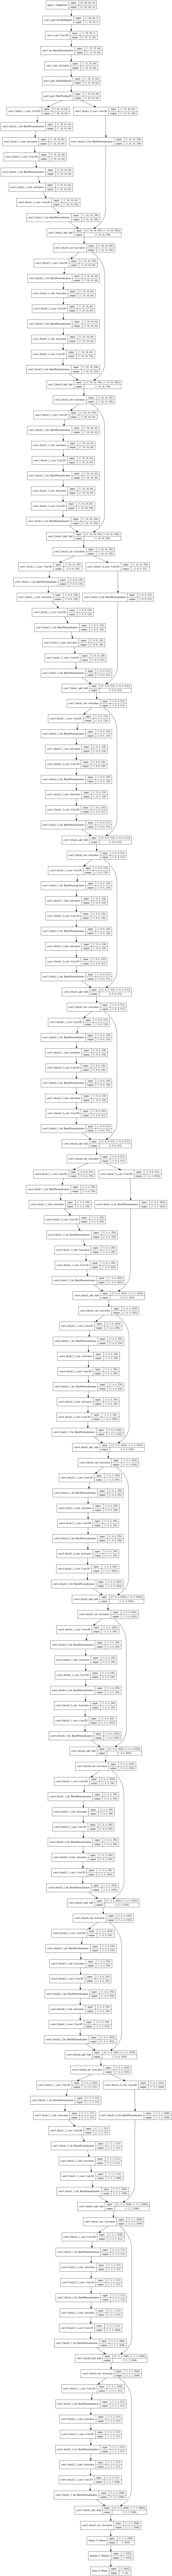

In [53]:
plot_model(model2, to_file='RES_model_plot.png', show_shapes=True, show_layer_names=True)

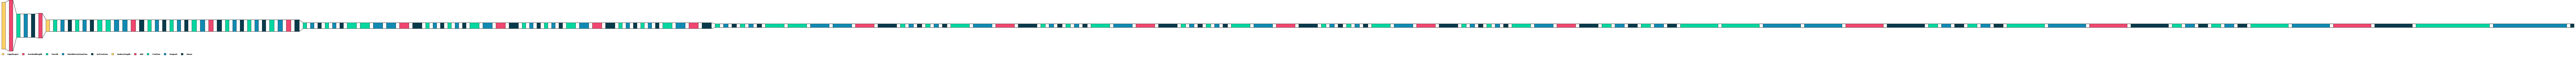

In [69]:

visualkeras.layered_view(model2, legend=True, draw_volume=False,spacing=20, to_file="RESmodel_vis.png")

In [23]:
model3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 65, 65, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128   

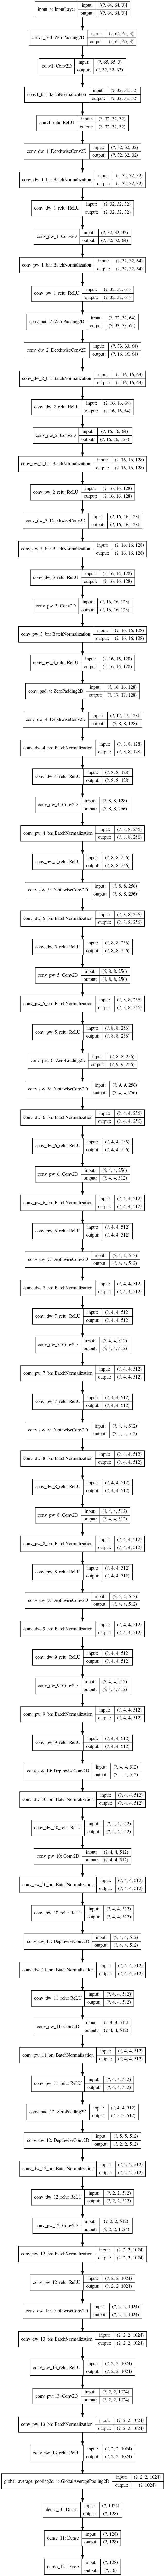

In [54]:
plot_model(model3, to_file='MOBIL_model_plot.png', show_shapes=True, show_layer_names=True)

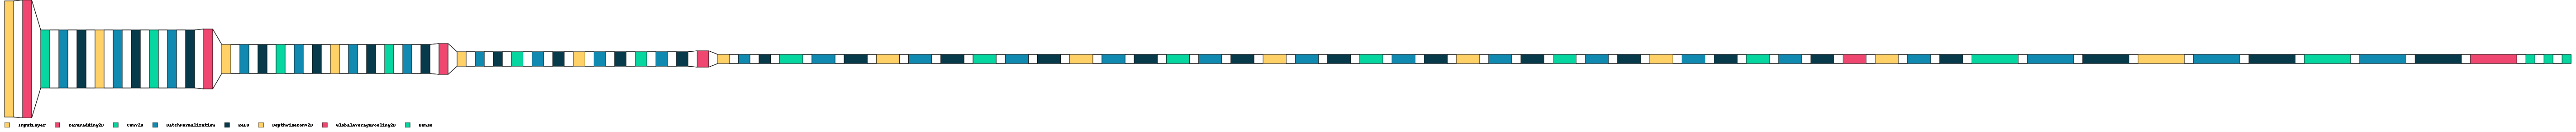

In [70]:

visualkeras.layered_view(model3, legend=True, draw_volume=False,spacing=20, to_file="MOBILEmodel_vis.png")

In [33]:
#fit the model
#it will take some time to train
history = model.fit(X_train, y_train, epochs =5, batch_size = 64,validation_data=(X_test,y_test))

Epoch 1/5
79/79 [==============================] - 3s 36ms/step - loss: 0.3825 - accuracy: 0.8946 - val_loss: 0.2520 - val_accuracy: 0.9278
Epoch 2/5
79/79 [==============================] - 3s 36ms/step - loss: 0.3309 - accuracy: 0.9093 - val_loss: 0.2138 - val_accuracy: 0.9481
Epoch 3/5
79/79 [==============================] - 3s 36ms/step - loss: 0.2743 - accuracy: 0.9270 - val_loss: 0.1824 - val_accuracy: 0.9565
Epoch 4/5
79/79 [==============================] - 3s 37ms/step - loss: 0.2344 - accuracy: 0.9403 - val_loss: 0.1596 - val_accuracy: 0.9630
Epoch 5/5
79/79 [==============================] - 3s 36ms/step - loss: 0.2210 - accuracy: 0.9381 - val_loss: 0.1582 - val_accuracy: 0.9556


In [37]:
#fit the model
#it will take some time to train
history2 = model2.fit(X_train, y_train, epochs =5, batch_size = 64,validation_data=(X_test,y_test))

Epoch 1/5
79/79 [==============================] - 10s 122ms/step - loss: 1.9929 - accuracy: 0.6298 - val_loss: 706.6956 - val_accuracy: 0.0241
Epoch 2/5
79/79 [==============================] - 7s 86ms/step - loss: 1.7903 - accuracy: 0.7490 - val_loss: 243.9247 - val_accuracy: 0.0343
Epoch 3/5
79/79 [==============================] - 7s 86ms/step - loss: 1.2659 - accuracy: 0.7706 - val_loss: 14.6348 - val_accuracy: 0.0324
Epoch 4/5
79/79 [==============================] - 7s 85ms/step - loss: 0.5787 - accuracy: 0.8810 - val_loss: 180.9432 - val_accuracy: 0.0213
Epoch 5/5
79/79 [==============================] - 7s 83ms/step - loss: 0.6301 - accuracy: 0.9018 - val_loss: 493.4237 - val_accuracy: 0.0343


In [38]:
#fit the model
#it will take some time to train
history3 = model3.fit(X_train, y_train, epochs =5, batch_size = 64,validation_data=(X_test,y_test))

Epoch 1/5
79/79 [==============================] - 2s 23ms/step - loss: 0.8354 - accuracy: 0.7712 - val_loss: 0.3163 - val_accuracy: 0.9130
Epoch 2/5
79/79 [==============================] - 1s 11ms/step - loss: 0.1726 - accuracy: 0.9492 - val_loss: 0.2607 - val_accuracy: 0.9269
Epoch 3/5
79/79 [==============================] - 1s 11ms/step - loss: 0.1128 - accuracy: 0.9677 - val_loss: 0.3069 - val_accuracy: 0.9222
Epoch 4/5
79/79 [==============================] - 1s 11ms/step - loss: 0.0772 - accuracy: 0.9804 - val_loss: 0.2532 - val_accuracy: 0.9398
Epoch 5/5
79/79 [==============================] - 1s 12ms/step - loss: 0.0288 - accuracy: 0.9909 - val_loss: 0.2109 - val_accuracy: 0.9546


In [ ]:
# Saving the model of vgg16
model.save('model_vgg16.h5')
# Saving the model of resnet
#model2.save('model_resnet.h5')

Accuracy of **VGG16**

In [39]:
score = model.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model.evaluate(x = X_eval, y = y_eval, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 95.556 %
Accuracy for evaluation images: 97.685 %


Accuracy of **RESNET50**

In [41]:
score = model2.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model2.evaluate(x = X_eval, y = y_eval, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 3.426 %
Accuracy for evaluation images: 2.13 %


Accuracy of MobileNet

In [42]:
score = model3.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model3.evaluate(x = X_eval, y = y_eval, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 95.463 %
Accuracy for evaluation images: 96.574 %


VGG16 accuracy and loss plot

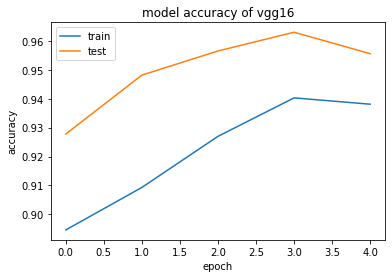

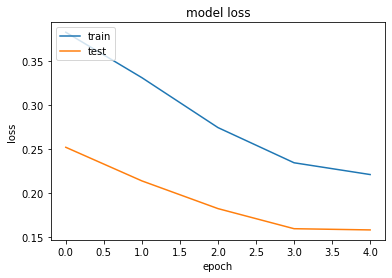

In [43]:
#vgg16
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy of vgg16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

resnet50 accuracy and loss plot

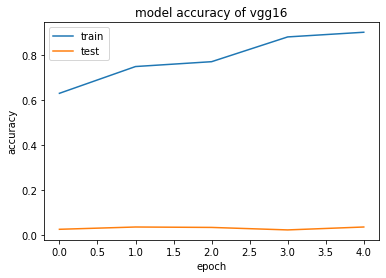

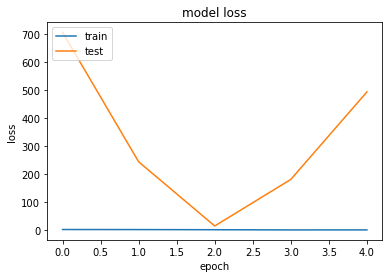

In [45]:
#Resnet
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy of vgg16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

MobileNet

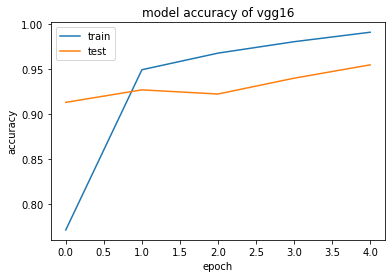

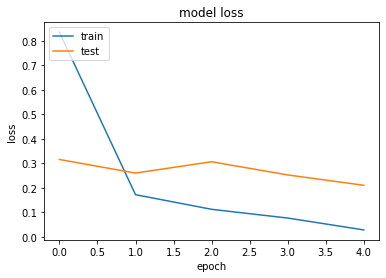

In [47]:
#Resnet
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy of vgg16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#from tensorflow import keras
#model = keras.models.load_model('/kaggle/input/model-files/mymodel.h5')

# VGG16 confusion matrix

 This will be the matrix for the testing data, which gave a high accuracy. We expect to find the diagonal elements to have large values with some values distributed in non-diagonal elements. Note that our the matrix is not normalized, and the total number of testing images per label were 300.

In [49]:
#Helper function to plot confusion matrix
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

from sklearn.metrics import confusion_matrix
import itertools


VGG16

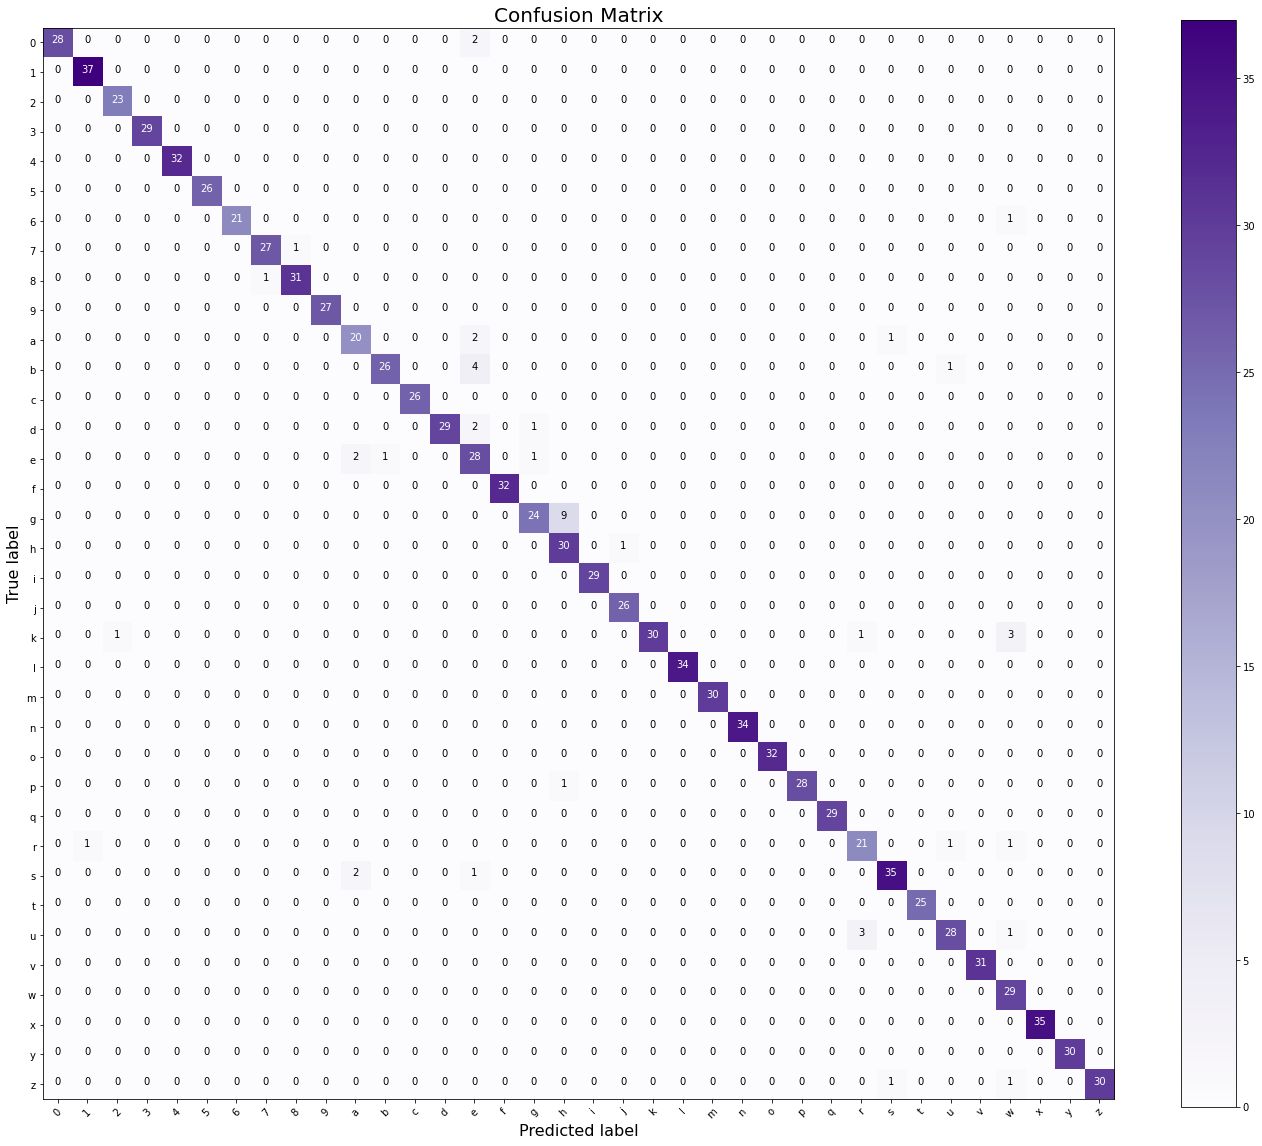

In [50]:
y_test_pred_VG = model.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred_VG)

MobileNet

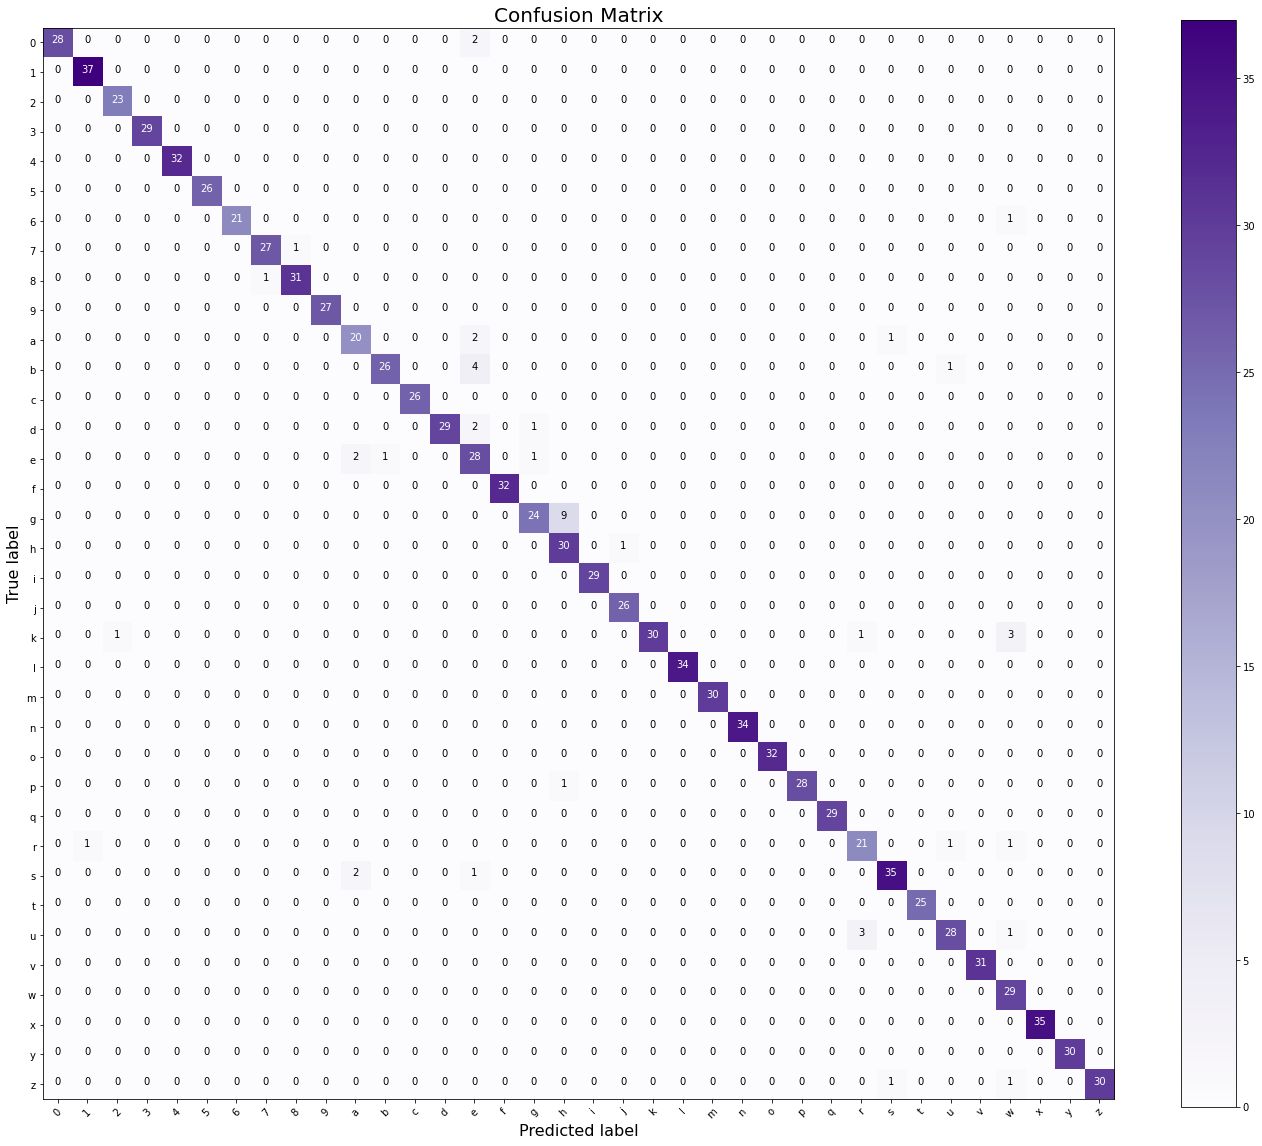

In [51]:
y_test_pred_MN = model.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred_MN)

In [ ]:
y_test_pred = model.predict (np.expand_dims (X_test [0], axis=0), batch_size = 1, verbose = 0)

In [ ]:
result = model.predict (np.expand_dims (X_test [0], axis=0), batch_size = 1, verbose = 0)

if result[0][0] == 1:
    prediction = '1'
elif result[0][1] == 1:
    prediction = '10'
elif result[0][2] == 1:
    prediction = '2'
elif result[0][3] == 1:
    prediction = '3'
elif result[0][4] == 1:
    prediction = '4'
elif result[0][5] == 1:
    prediction = '5'
elif result[0][6] == 1:
    prediction = '6'
elif result[0][7] == 1:
    prediction = '7'
elif result[0][8] == 1:
    prediction = '8'
elif result[0][9] == 1:
    prediction = '9'
elif result[0][10] == 1:
    prediction = 'A'
elif result[0][11] == 1:
    prediction = 'B'
elif result[0][12] == 1:
    prediction = 'C'
elif result[0][13] == 1:
    prediction = 'D'
elif result[0][14] == 1:
    prediction = 'E'
elif result[0][15] == 1:
    prediction = 'F'
elif result[0][16] == 1:
    prediction = 'G'
elif result[0][17] == 1:
    prediction = 'H'
elif result[0][18] == 1:
    prediction = 'I'
elif result[0][19] == 1:
    prediction = 'J'
elif result[0][20] == 1:
    prediction = 'K'
elif result[0][21] == 1:
    prediction = 'L'
elif result[0][22] == 1:
    prediction = 'M'
elif result[0][23] == 1:
    prediction = 'N'
elif result[0][24] == 1:
    prediction = 'O'
elif result[0][25] == 1:
    prediction = 'P'
elif result[0][26] == 1:
    prediction = 'Q'
elif result[0][27] == 1:
    prediction = 'R'
elif result[0][28] == 1:
    prediction = 'S'
elif result[0][29] == 1:
    prediction = 'T'
elif result[0][30] == 1:
    prediction = 'U'
elif result[0][31] == 1:
    prediction = 'V'
elif result[0][32] == 1:
    prediction = 'W'
elif result[0][33] == 1:
    prediction = 'X'
elif result[0][34] == 1:
    prediction = 'Y'
elif result[0][35] == 1:
    prediction = 'Z'
    
print(prediction)



In [ ]:
print(result)

**Next I will plot the confusion matrix for the evaluation images**

In [ ]:
y_eval_pred = model.predict(X_eval, batch_size = 512,verbose = 0)
plot_confusion_matrix(y_eval, y_eval_pred)

# RESNET50 confusion matrix

In [ ]:
'''
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

from sklearn.metrics import confusion_matrix
import itertools

y_test_pred = model2.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

'''


In [ ]:
#y_eval_pred = model2.predict(X_eval, batch_size = 64, verbose = 0)
#plot_confusion_matrix(y_eval, y_eval_pred)

In [ ]:
from tensorflow.keras.models import load_model

# Load the VGG16 model
#model_vgg16 = load_model('/kaggle/input/model-files/mymodel.h5')

In [ ]:
# for only one prediction
import numpy as np
from keras.preprocessing import image
#test_image = image.load_img('/kaggle/input/american-sign-language-09az/American/0/1.jpg',target_size=(64,64))
test_image = cv2.resize(cv2.imread("/kaggle/input/american-sign-language-recognition/test_set/9/105.png"), (64, 64))
plt.imshow(test_image)

test_image = np.asarray(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image.astype('float32')/255.0

result = np.argmax(model.predict(test_image))

if result == 0:
    prediction = '0'
elif result == 1:
    prediction = '1'
elif result == 2:
    prediction = '2'
elif result == 3:
    prediction = '3'
elif result == 4:
    prediction = '4'
elif result == 5:
    prediction = '5'
elif result == 6:
    prediction = '6'
elif result == 7:
    prediction = '7'
elif result == 8:
    prediction = '8'
elif result == 9:
    prediction = '9'
elif result == 10:
    prediction = 'A'
elif result == 11:
    prediction = 'B'
elif result == 12:
    prediction = 'C'
elif result == 13:
    prediction = 'D'
elif result == 14:
    prediction = 'E'
elif result == 15:
    prediction = 'F'
elif result == 16:
    prediction = 'G'
elif result == 17:
    prediction = 'H'
elif result == 18:
    prediction = 'I'
elif result == 19:
    prediction = 'J'
elif result == 20:
    prediction = 'K'
elif result == 21:
    prediction = 'L'
elif result == 22:
    prediction = 'M'
elif result == 23:
    prediction = 'N'
elif result == 24:
    prediction = 'O'
elif result == 25:
    prediction = 'P'
elif result == 26:
    prediction = 'Q'
elif result == 27:
    prediction = 'R'
elif result == 28:
    prediction = 'S'
elif result == 29:
    prediction = 'T'
elif result == 30:
    prediction = 'U'
elif result == 31:
    prediction = 'V'
elif result == 32:
    prediction = 'W'
elif result == 33:
    prediction = 'X'
elif result == 34:
    prediction = 'Y'
elif result == 35:
    prediction = 'Z'
    
print(prediction)



##Load Model

Creating Tensorflow lite model

In [ ]:

# Loading Keras model
#model = tf.keras.models.load_model("/kaggle/input/model-files/mymodel.h5")

# Converting the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Saving the model
with open("model.tflite", "wb") as f:
  f.write(tflite_model)


In [ ]:

# Load your TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="/kaggle/working/model.tflite")

# Allocate tensors
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

test_image = cv2.resize(cv2.imread("/kaggle/input/american-sign-language-recognition/test_set/9/105.png"), (64, 64))
plt.imshow(test_image)

test_image = np.asarray(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image.astype('float32')/255.0

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], test_image)

# Invoke the model
interpreter.invoke()

# Get the output tensor
result = np.argmax(interpreter.get_tensor(output_details[0]['index']))

#result = np.argmax(model.predict(test_image))

if result == 0:
    prediction = '0'
elif result == 1:
    prediction = '1'
elif result == 2:
    prediction = '2'
elif result == 3:
    prediction = '3'
elif result == 4:
    prediction = '4'
elif result == 5:
    prediction = '5'
elif result == 6:
    prediction = '6'
elif result == 7:
    prediction = '7'
elif result == 8:
    prediction = '8'
elif result == 9:
    prediction = '9'
elif result == 10:
    prediction = 'A'
elif result == 11:
    prediction = 'B'
elif result == 12:
    prediction = 'C'
elif result == 13:
    prediction = 'D'
elif result == 14:
    prediction = 'E'
elif result == 15:
    prediction = 'F'
elif result == 16:
    prediction = 'G'
elif result == 17:
    prediction = 'H'
elif result == 18:
    prediction = 'I'
elif result == 19:
    prediction = 'J'
elif result == 20:
    prediction = 'K'
elif result == 21:
    prediction = 'L'
elif result == 22:
    prediction = 'M'
elif result == 23:
    prediction = 'N'
elif result == 24:
    prediction = 'O'
elif result == 25:
    prediction = 'P'
elif result == 26:
    prediction = 'Q'
elif result == 27:
    prediction = 'R'
elif result == 28:
    prediction = 'S'
elif result == 29:
    prediction = 'T'
elif result == 30:
    prediction = 'U'
elif result == 31:
    prediction = 'V'
elif result == 32:
    prediction = 'W'
elif result == 33:
    prediction = 'X'
elif result == 34:
    prediction = 'Y'
elif result == 35:
    prediction = 'Z'
    
print(prediction)

